# ANALYSING EMOTIONS FROM HAND SKETCHED DOODLES


#### by Sayantani Dey


### Importing Libraries


In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.optim import AdamW
import os

### Defining Transformations


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for 3 channels
])


### Loading Datasets


In [3]:
data_dir = "drawings"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

dataset_train = ImageFolder(root=train_dir, transform=transform)
dataset_val = ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)

### Pretrained ViT Model


In [4]:
# Loading model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=2,
    ignore_mismatched_sizes=True  # Allows resizing classifier layer
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Set up optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

In [6]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(dataloader), correct / len(dataset_train)

In [7]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(dataloader), correct / len(dataset_val)

### Training Model


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")


Epoch 1/5: Train Loss=0.5134, Train Acc=0.6750, Val Loss=0.2505, Val Acc=0.9500
Epoch 2/5: Train Loss=0.1148, Train Acc=1.0000, Val Loss=0.1635, Val Acc=1.0000
Epoch 3/5: Train Loss=0.0508, Train Acc=1.0000, Val Loss=0.1090, Val Acc=1.0000
Epoch 4/5: Train Loss=0.0243, Train Acc=1.0000, Val Loss=0.0782, Val Acc=1.0000
Epoch 5/5: Train Loss=0.0123, Train Acc=1.0000, Val Loss=0.0611, Val Acc=1.0000


### Testing Model


In [9]:
from PIL import Image

def predict_image(model, image_path, transform, device):
    model.eval()  # Set model to evaluation mode
    image = Image.open(image_path).convert("RGB")  # Ensure RGB format
    image = transform(image).unsqueeze(0).to(device)  # Apply transformations and add batch dimension

    with torch.no_grad():
        output = model(image).logits
        prediction = torch.argmax(output, dim=1).item()

    class_names = dataset_train.classes  # Get class labels from dataset
    return class_names[prediction]


In [10]:
image_path = "drawings/test/201.jpg"  # Path to your test image
prediction = predict_image(model, image_path, transform, device)
print(f"Predicted class: {prediction}")


Predicted class: Bad


In [11]:
image_path = "drawings/test/204.jpg"  # Path to your test image
prediction = predict_image(model, image_path, transform, device)
print(f"Predicted class: {prediction}")


Predicted class: Bad


In [12]:
image_path = "drawings/test/205.jpg"  # Path to your test image
prediction = predict_image(model, image_path, transform, device)
print(f"Predicted class: {prediction}")


Predicted class: Bad


In [13]:
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

### Evaluation


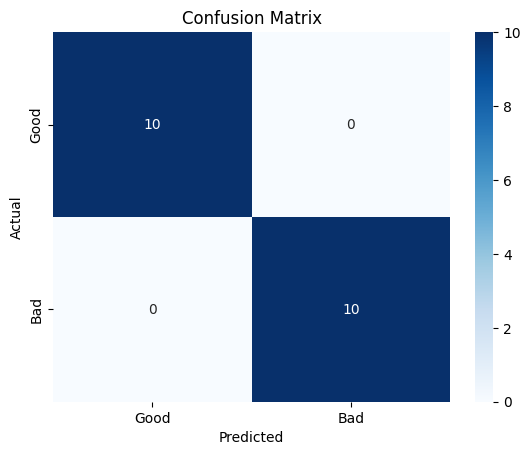

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Good", "Bad"], yticklabels=["Good", "Bad"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Call it after training:
plot_confusion_matrix(model, val_loader, device)

### Precision-Recall Curve & ROC-AUC Curve


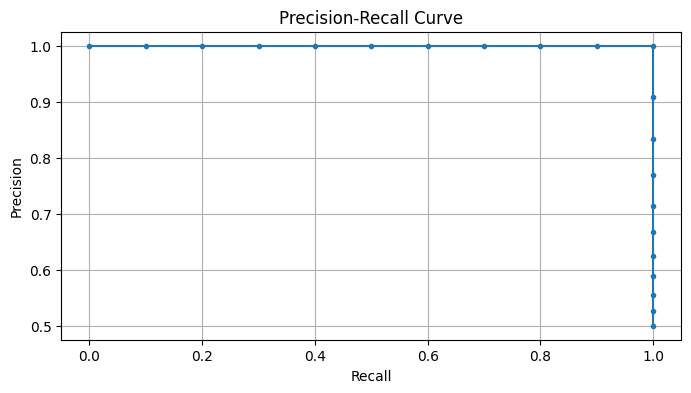

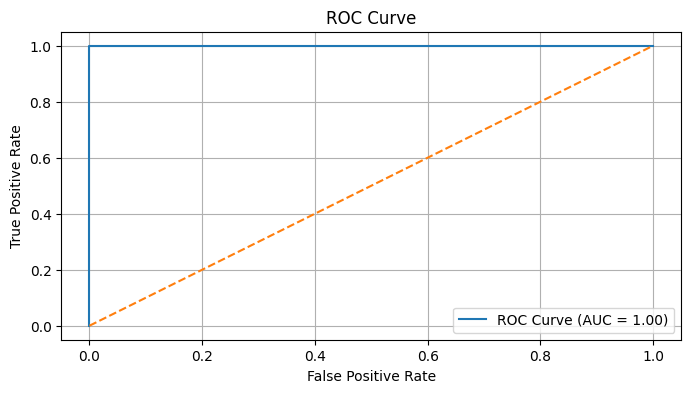

In [15]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_pr_roc_curves(model, dataloader, device):
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Prob of class "Bad"
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Precision-Recall
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    plt.figure(figsize=(8, 4))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 4))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

# Call after model validation
plot_pr_roc_curves(model, val_loader, device)
